### Lập trình MLP từ đầu

In [1]:
from d2l import mxnet as d2l
from mxnet import gluon, np, npx, autograd
npx.set_np()

Để so sánh với mô hình hồi quy softmax thì ta sẽ sử dụng bộ dữ liệu phân loại ảnh Fashion-MNIST. 

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### 1. Khởi tạo tham số của mô hình
- Fashion-MNIST có 10 lớp, mỗi ảnh là một lưới có 28 x 28 = 784 điểm ảnh đen và trắng. Ta sẽ tạm thời bỏ qua mối liên hệ về mặt không gian giữa các điểm ảnh và coi chúng như một tập dữ liệu với 784 đặc trưng đầu vào và 10 lớp. 
- Để bắt đầu, ta sẽ lập trình một mạng MLP chỉ có một tầng ẩn với 256 nút ẩn.
- Lưu ý rằng ta coi cả hai đại lượng trên là các siêu tham số và ta nên thiết lập giá trị cho chúng dựa vào chất lượng trên tập kiểm định. Thông thường, ta sẽ chọn độ rộng của các tầng là lũy thừa bậc 2 để giúp việc tính toán hiệu quả hơn do cách mà bộ nhớ được cấp phát ở phần cứng.

In [3]:
num_inputs, num_outputs, num_hidden = 784, 10, 256

W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hidden))
b1 = np.zeros(num_hidden)

W2 = np.random.normal(scale = 0.01, size = (num_hidden, num_outputs))
b2 = np.zeros(num_outputs)

params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

type(W1)


mxnet.numpy.ndarray

#### 2. Hàm kích hoạt
- Ta sẽ tự lập trình hàm kích hoạt ReLU bằng cách sử dụng hàm maximum

In [4]:
def ReLU(x):
    return np.maximum(x, 0)

#### 3. Mô hình
- Vì ta đang bỏ qua mối liên hệ về mặt không gian giữa các điểm ảnh, ta reshape mỗi bức ảnh 2D thành một vector phẳng có độ dài num_inputs.

In [5]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = ReLU(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

#### 4. Hàm loss
- Ta sử dụng hàm số tích hợp sẵn của Gluon để tính softmax và mất mát entropy chéo.

In [6]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

#### 5. Huấn luyện
- Ta tiến hành viết hàm huấn luyện cho mỗi epoch và hàm train tổng quát.

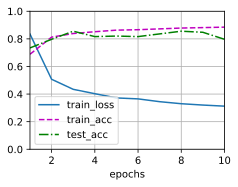

In [7]:

def train_epoch(net, train_iter, loss, trainer):
    # train_loss, train_acc, total_example
    metrics = d2l.Accumulator(3)
    
    if (isinstance(trainer, gluon.Trainer)):
        trainer = trainer.step
    # print(trainer)
    for X, y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        trainer(len(y))
        metrics.add(l.sum(), d2l.accuracy(npx.softmax(y_hat), y), len(y))
    
    return metrics[0] / metrics[2], metrics[1] / metrics[2]

def train(num_epoch, net, train_iter, test_iter, loss, trainer):
    anim = d2l.Animator(
        xlabel="epochs", ylabel=None, legend = ["train_loss", "train_acc", "test_acc"],
        xlim = [1, 10], ylim=[0, 1]
    )

    for epoch in range(num_epoch):
        (train_loss, train_acc) = train_epoch(net, train_iter, loss, trainer)
        for X, y in test_iter:
            test_acc = d2l.accuracy(npx.softmax(net(X)), y) / len(y)
            break
        anim.add([epoch + 1] * 3, [train_loss, train_acc, test_acc])


num_epoch, lr = 10, 0.5
trainer =  lambda batch_size: d2l.sgd(params, lr, batch_size)
print(trainer, params[2].grad, batch_size)
train(num_epoch, net, train_iter, test_iter, loss, trainer)

        

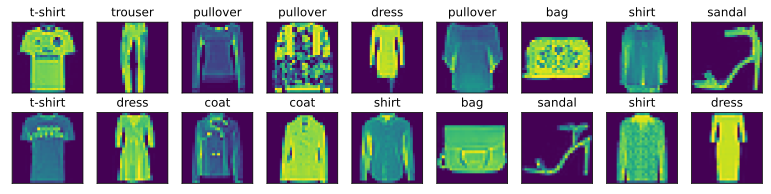

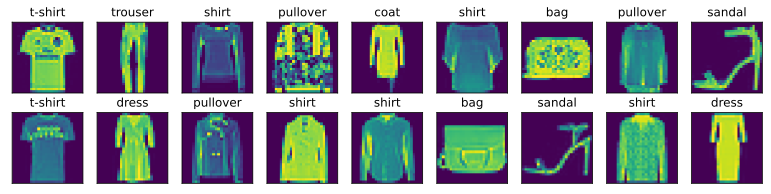

In [18]:
from matplotlib import pyplot as plt
def predict(net, test_iter, nrow, ncol, true_label = True):
    scale = 1.5
    figsize = (ncol * scale, nrow * scale)
    fig, axes = plt.subplots(ncols= ncol, nrows= nrow, figsize = figsize)
    axes = axes.flatten()
    for X, y in test_iter:
        break
    if (true_label):
        titles = d2l.get_fashion_mnist_labels(y)
    else:
        titles = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    imgs = X.squeeze(1)
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(titles[i])


predict(net, test_iter, 2, 9)
predict(net, test_iter, 2, 9, False)
